# Secretory Reactions
Here we will map all the secretory reactions from the [Mammalian Secretory Pathway Reconstruction paper](https://www.nature.com/articles/s41467-019-13867-y) to the genes in our reconstruction.

1. Load Secretory Pathway Reactions

In [1]:
import re
import pandas as pd
import numpy as np
from google_sheet import GoogleSheet

import matplotlib.pyplot as plt
from matplotlib_venn import venn3

from cobra.io import load_json_model, read_sbml_model
from cobra import Model, Reaction, Metabolite

In [2]:
import importlib
import iCHOSEC_Builder

from iCHOSEC_Builder import iCHOSEC_Builder

In [3]:
##### ----- Generate datasets from Google Sheet ----- #####

#Credential file
KEY_FILE_PATH = 'credentials.json'

#CHO Network Reconstruction + Recon3D_v3 Google Sheet ID
Sec_Recon_SPREADSHEET_ID = '1DaAdZlvMYDqb7g31I5dw-ZCZH52Xj_W3FnQMFUzqmiQ'

# Initialize the GoogleSheet object
sec_recon_gsheet_file = GoogleSheet(Sec_Recon_SPREADSHEET_ID, KEY_FILE_PATH)

# Read data from SecRecon
sec_reactions_sheet = 'Reactions'
sec_reactions = sec_recon_gsheet_file.read_google_sheet(sec_reactions_sheet)

In [4]:
# Load model
model = read_sbml_model('Models/iCHOv1_final.xml')
#model = load_json_model('Models/iCHO3595.json')

In [14]:
# Sec Recon Reaction Files
rxnFormula = list(sec_reactions['Reaction Formula'])
rxnAbbreviation = list(sec_reactions['Reaction'])
rxnPathway = list(sec_reactions['Pathway'])
rxnConditions = list(sec_reactions['Conditions'])
rxnGPR = list(sec_reactions['GPR_final'])
rxnGPR = ['' if x is None else x for x in rxnGPR] # transform None values to empty string
rxnComponents = list(sec_reactions['Components'])

# CHO PSIM
PSIM = pd.read_csv('PSIM/PSIM_CHO.tab', sep='\t')
PSIM.fillna({'Location': ''}, inplace=True) # Replace NaN values in the 'Location' column with empty strings
PSIM.set_index('Entry', inplace=True)

In [15]:
# Define the entry ID you are looking for
entryID = 'G3HGQ6'

# Create the Protein Specific Information (PSI) list
PSI = PSIM.loc[entryID]

In [16]:
PSI

Protein names                                          Plasminogen
Length                                                         697
Mass                                                       78033.0
SP                                                               1
DSB                                                              4
GPI                                                              0
NG                                                               0
OG                                                               0
TMD                                                              0
Location                                                          
Sequence         MDHKEVVLLFLLFLRSGQGLSLDGYVSTQGASLFSLTKKQVGARSI...
Name: G3HGQ6, dtype: object

In [17]:
builder = iCHOSEC_Builder(PSIM=PSIM,
                          entryID=entryID,
                          rxnPathway=rxnPathway,
                          rxnFormula=rxnFormula,
                          rxnAbbreviation=rxnAbbreviation,
                          rxnConditions=rxnConditions,
                          rxnGPR=rxnGPR,
                          rxnComponents = rxnComponents
                         )


            Protein: Plasminogen
            Length: 697.0
            MW: 78033.0
            Signal Peptide: 1
            Disulfide Bonds: 4
            


In [18]:
# Generate lists for reactions (rxns), reaction names (rxnNames), and Gene-Protein-Reactions (GPRs)
rxns, rxnNames, GPRs = builder.generateProteinSpecificRxns_A()

sec_reactions_dict = {}
for name, rxn, gpr in zip(rxnNames, rxns, GPRs):
    sec_reactions_dict[name] = {'rxn': rxn, 'GPR': gpr}

In [19]:
# Initialize new model
secretory_model = model.copy()

# Add Sec Recon Reactions IDs
sec_r = []
for rxn in sec_reactions_dict.keys():
    r = Reaction(rxn.strip())
    sec_r.append(r)
secretory_model.add_reactions(sec_r)

for r in secretory_model.reactions:
    if r in sec_r:
        r.build_reaction_from_string(sec_reactions_dict[r.id]['rxn'])
        r.gene_reaction_rule = str(sec_reactions_dict[r.id]['GPR'])
        print(r.reaction)
        print(f"Lower bound: {r.lower_bound}, Upper bound: {r.upper_bound}")

unknown metabolite 'G3HGQ6_c' created
35.0 ala_L_c + 38.0 arg_L_c + 31.0 asn_L_c + 34.0 asp_L_c + 698.0 atp_c + 38.0 cys_L_c + 30.0 gln_L_c + 43.0 glu_L_c + 56.0 gly_c + 1392.0 gtp_c + 1393.0 h2o_c + 14.0 his_L_c + 25.0 ile_L_c + 43.0 leu_L_c + 46.0 lys_L_c + 13.0 met_L_c + 20.0 phe_L_c + 53.0 pro_L_c + 49.0 ser_L_c + 42.0 thr_L_c + 16.0 trp_L_c + 28.0 tyr_L_c + 43.0 val_L_c --> G3HGQ6_c + adp_c + 697.0 amp_c + 1392.0 gdp_c + 1393.0 h_c + 1393.0 pi_c + 697.0 ppi_c
Lower bound: 0, Upper bound: 1000.0
unknown metabolite 'SRP_c' created
unknown metabolite 'G3HGQ6-SRP_c' created
G3HGQ6_c + SRP_c --> G3HGQ6-SRP_c
Lower bound: 0, Upper bound: 1000.0
unknown metabolite 'SRPR_r' created
unknown metabolite 'RRBP1_r' created
unknown metabolite 'G3HGQ6-SRP-SRPR-RRBP1_c' created
G3HGQ6-SRP_c + RRBP1_r + SRPR_r --> G3HGQ6-SRP-SRPR-RRBP1_c
Lower bound: 0, Upper bound: 1000.0
unknown metabolite 'SEC61C_r' created
unknown metabolite 'G3HGQ6-SRP-SRPR-SEC61C_c' created
G3HGQ6-SRP-SRPR-RRBP1_c + SEC61C_r

In [20]:
secretory_model.objective = entryID + '_Final_demand'
secretory_model.slim_optimize() # mmol of target protein/gDW/h

0.00017882624999999996

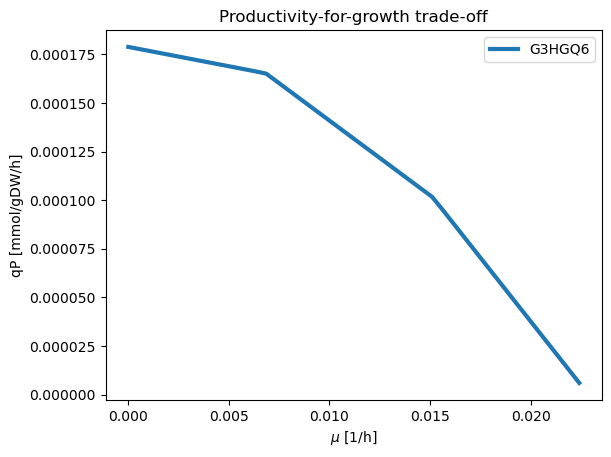

In [22]:

# Plot Pareto frontier of secretion-for-growth trade-off
secretory_model.objective = 'biomass_cho_producing'
max_growth = secretory_model.slim_optimize()
secretory_model.objective = entryID + '_Final_demand'
steps = 50
x = [max_growth/steps * i for i in range(steps)]
y = [0] * len(x)
for n in range(steps):
    mu_constraint = x[n]
    secretory_model.reactions.get_by_id('biomass_cho_producing').lower_bound = mu_constraint
    y[n] = secretory_model.slim_optimize()
plt.plot(x,y,linewidth=3,label=entryID)
plt.legend()
plt.xlabel('$\mu$ [1/h]')
plt.ylabel('qP [mmol/gDW/h]')
plt.title('Productivity-for-growth trade-off')
plt.savefig('modeling_plots/productivity_for_growth_tradeoff.png', format='png', dpi=300)
plt.show()

In [10]:
## Fill in the PSIV of your protein here ##
# The format must be PSIV = ['Protein names', 'Length', 'Mass', 'SP', 'DSB', 'GPI', 'NG', 'OG', 'TMD', 'Location', 'Sequence']
# Example: PSIV = ['MyProtein','MAHFRTEYPNVCWQGED',100.0,'1','0','0','0','0','[e]']
##PSIV = []

entryID = 'Q15U'
PSIV = ['MyProtein',17,100.0,'1','0','0','0','0','0','[e]','MAHFRTEYPNVCWQGED']
builder_2 = iCHOSEC_Builder(PSIV=PSIV,
                          entryID=entryID,
                          rxnPathway=rxnPathway,
                          rxnFormula=rxnFormula,
                          rxnAbbreviation=rxnAbbreviation,
                          rxnConditions=rxnConditions,
                          rxnGPR=rxnGPR,
                          rxnComponents = rxnComponents
                         )


            Protein: MyProtein
            Length: 17.0
            MW: 100.0
            Signal Peptide: 1
            Disulfide Bonds: 0
            
